# ViT + BERT

This model integrates the Vision Transformer (ViT) for image encoding with BERT, a bidirectional transformer, for caption generation. ViT encodes the image into patch embeddings, while BERT translates these embeddings into coherent captions.

## Import Library

In [ ]:
!pip install pycocoevalcap

!pip install -U nltk
!pip install nltk==3.5

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.bleu.bleu import Bleu
import os
import zipfile
import torch.nn as nn
from torch.optim import AdamW, Adam
from transformers import get_scheduler
from torch.optim.lr_scheduler import OneCycleLR
import re

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from collections import Counter
from math import log, sqrt

import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Data Preparation

To train this model, we use the MS-COCO dataset, which contains thousands of images paired with human-generated captions.

The preprocessing pipeline transforms raw images into a format suitable for patch embedding and subsequent transformer processing. The provided preprocessing steps use the Albumentations library for augmentations and normalization.
* Augments the dataset with realistic transformations to improve generalization.
* Standardizes image dimensions and pixel distributions for compatibility with the Vision Transformer.
* Balances augmentation to prevent overfitting while retaining essential visual features.

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

class ImageCaptionDataset(Dataset):
    def __init__(self, text_df, tokenizer, image_height, image_width, augment=True):
        self.text_df = text_df
        self.tokenizer = tokenizer
        self.image_height = image_height
        self.image_width = image_width
        self.augment = augment
        
        # Define Albumentations transforms
        self.train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.ColorJitter(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
            A.HueSaturationValue(p=0.3),
            A.Resize(self.image_height, self.image_width),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True)
        ])
        
        self.val_transforms = A.Compose([
            A.Resize(self.image_height, self.image_width),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True)
        ])

    def __len__(self):
        return len(self.text_df)
    
    def __getitem__(self, index):
        image_filename = self.text_df.iloc[index]['image']
        
        # Load image
        image = Image.open(image_filename).convert("RGB")
        image = np.array(image)  # Convert PIL image to numpy array
        
        # Apply Albumentations transforms
        if self.augment:
            transformed = self.train_transforms(image=image)
        else:
            transformed = self.val_transforms(image=image)
        
        image = transformed["image"]  # Extract transformed image tensor
        # Resize and convert to numpy array
        image = np.array(image)
        image = torch.tensor(np.moveaxis(image, -1, 0))  # Convert HWC to CHW (PyTorch format)
        
        # Tokenize caption
        caption_token = self.tokenizer(
            self.text_df.iloc[index]['caption'], 
            add_special_tokens=True, 
            padding="max_length", 
            max_length=32, 
            truncation=True
        ).input_ids 
        caption_token = [token if token != self.tokenizer.pad_token_id else -100 for token in caption_token]
        
        return {"pixel_values": image, "caption_token": torch.tensor(caption_token)}


In [4]:
# path to images

coco_train_images = "/kaggle/input/coco-2017-dataset/coco2017/train2017/"
coco_val_images = "/kaggle/input/coco-2017-dataset/coco2017/val2017/"

In [5]:
# Load image and caption Dataframe

train_df = pd.read_csv("/kaggle/input/coco-df/df_coco_train_complete.csv", index_col=False)
# train_df.drop('Unnamed: 0', axis=1, inplace=True)

val_df = pd.read_csv("/kaggle/input/coco-df/df_coco_val_complete.csv", index_col=False)
# val_df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
train_df.head()

,image,caption
0,/kaggle/input/coco-2017-dataset/coco2017/train...,A white boom box with an mp3 player on top of it.
1,/kaggle/input/coco-2017-dataset/coco2017/train...,Young kid swings bat at baseball in the flied
2,/kaggle/input/coco-2017-dataset/coco2017/train...,Two beach chairs and an umbrella on a beach.
3,/kaggle/input/coco-2017-dataset/coco2017/train...,A close up of a street pole with no parking si...
4,/kaggle/input/coco-2017-dataset/coco2017/train...,A woman with glasses eats a hot dog in a bleac...


In [7]:
val_df.head()

,image,caption
0,/kaggle/input/coco-2017-dataset/coco2017/val20...,A pizza covered in lots of greens on top of a ...
1,/kaggle/input/coco-2017-dataset/coco2017/val20...,Two giraffe standing in a green grass covered ...
2,/kaggle/input/coco-2017-dataset/coco2017/val20...,An assortment of doughnuts are arranged in a d...
3,/kaggle/input/coco-2017-dataset/coco2017/val20...,A woman flies a kite near a young child.
4,/kaggle/input/coco-2017-dataset/coco2017/val20...,A woman sits on a chair and watches a vintage TV.


## Vision Encoder Decoder Models

Vision Transformer (ViT):
The image is divided into patches, and each patch is embedded into a vector. These embeddings are processed through transformer layers.

BERT Decoder:
BERT receives the image embeddings and generates a caption word by word.

In [8]:
# # Setting up model

# from PIL import Image
# import requests

# image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
# decoder_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# if decoder_tokenizer.pad_token is None:
#     decoder_tokenizer.pad_token = '[PAD]'

# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224", "bert-base-uncased")

# model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
# model.config.pad_token_id = decoder_tokenizer.pad_token_id
# model.config.vocab_size = model.config.decoder.vocab_size

In [9]:
# Load trained model

model_path = "/kaggle/input/vit-bert-pretrained/vit_bert_last (6)/vit_bert_model"

# File paths inside the model directory
config_file = f"{model_path}/config.json"
special_tokens_map = f"{model_path}/special_tokens_map.json"
tokenizer_file = f"{model_path}/tokenizer.json"
vocab_file = f"{model_path}/vocab.txt"
model_weights = f"{model_path}/pytorch_model.bin"


In [10]:
# Load the trained model
model = VisionEncoderDecoderModel.from_pretrained(model_path)

# Load the tokenizer for the decoder (BERT tokenizer)
decoder_tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load the image processor for the encoder
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Ensure pad token is set
if decoder_tokenizer.pad_token is None:
    decoder_tokenizer.pad_token = '[PAD]'

# Update model config
model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
model.config.pad_token_id = decoder_tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

print("Model, tokenizer, and image processor loaded successfully!")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Model, tokenizer, and image processor loaded successfully!


In [11]:
# Create datasets and dataloaders

train_dataset = ImageCaptionDataset(text_df=train_df, tokenizer=decoder_tokenizer, image_height=224, image_width=224, augment=True)
val_dataset = ImageCaptionDataset(text_df=val_df, tokenizer=decoder_tokenizer, image_height=224, image_width=224, augment=True)

In [12]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=3)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=3)

In [13]:
len(train_dataloader)

15625

## Training Setup

* Batch Size: 32, selected to balance GPU memory limitations and ensure stable gradient updates.
* Learning Rate: 0.00001, chosen for fine-tuning pre-trained models to allow gradual and stable weight updates.
* Optimizer: Adam, used for its momentum and adaptive learning rate capabilities, aiding efficient convergence.
* Loss Function: CrossEntropyLoss, utilized to measure the difference between predicted and ground-truth sequences in image captioning tasks.
* Learning Rate Scheduler: OneCycleLR, dynamically adjusted the learning rate by starting low, peaking mid-training, and reducing it towards the end to accelerate convergence and minimize overfitting.

In [14]:
# Set up training

optimizer = Adam(model.parameters(), lr=1e-5)

epochs = 10
num_training_steps = epochs * len(train_dataloader)

scheduler = OneCycleLR(optimizer, max_lr=1e-5, total_steps=num_training_steps)

criterion = nn.CrossEntropyLoss(ignore_index=-100) 

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
print(device)

model.to(device)

cuda


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [15]:
# zip file
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

In [ ]:
# Training process

def evaluate_validation_loss_cross_entropy(model, val_dataloader, criterion, device):
    model.eval()
    val_losses = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(pixel_values=batch['pixel_values'], labels=batch['caption_token'])
            logits = outputs.logits
            target = batch['caption_token']
            logits = logits.view(-1, logits.size(-1))
            target = target.view(-1)
            loss = criterion(logits, target)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    return avg_val_loss

model.train()
for epoch in range(epochs):
    epoch_losses = []

    print(f"Starting Epoch {epoch+1}/{epochs}")
    
    for batch_idx, batch in enumerate(train_dataloader, start=1):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values=batch['pixel_values'], labels=batch['caption_token'])
        logits = outputs.logits
        target = batch['caption_token']
        logits = logits.view(-1, logits.size(-1))
        target = target.view(-1)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        epoch_losses.append(loss.item())

        if batch_idx % 1000 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}")

    avg_val_loss = evaluate_validation_loss_cross_entropy(model, val_dataloader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")

    save_directory = "vit_bert_model"
    model.save_pretrained(save_directory)
    decoder_tokenizer.save_pretrained(save_directory)
    print(f"Model saved to {save_directory}")

    with zipfile.ZipFile('vit_bert_last.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipdir('/kaggle/working/vit_bert_model', zipf)
    
    print("Model folder has been zipped to vit_bert_last.zip.")


## Evaluation

To assess the performance of the image captioning models, we use the following metrics:

* BLEU (Bilingual Evaluation Understudy): Measures how many n-grams in the generated caption overlap with the reference captions.

> BLEU-1: Measures unigram precision.
BLEU-2, BLEU-3, BLEU-4: Extend to bigrams, trigrams, and 4-grams, respectively.

* METEOR (Metric for Evaluation of Translation with Explicit ORdering): Considers precision, recall, and alignment by matching words and phrases. It accounts for synonyms and stemming, making it more semantically aware.

* ROUGE-L (Recall-Oriented Understudy for Gisting Evaluation): Focuses on the longest common subsequence (LCS) between the generated and reference captions, capturing sentence-level structure.

In [17]:
grouped_val_df = val_df.groupby('image')['caption'].apply(list).reset_index()
grouped_val_df.head()

,image,caption
0,/kaggle/input/coco-2017-dataset/coco2017/val20...,"[A person standing at a table in a room., A li..."
1,/kaggle/input/coco-2017-dataset/coco2017/val20...,[Closeup of a brown bear sitting in a grassy a...
2,/kaggle/input/coco-2017-dataset/coco2017/val20...,[This room has a bed with blue sheets and a la...
3,/kaggle/input/coco-2017-dataset/coco2017/val20...,[A stop sign installed upside down on a street...
4,/kaggle/input/coco-2017-dataset/coco2017/val20...,"[Three teddy bears, each a different color, sn..."


In [18]:
def generate_caption(image, model, tokenizer, device):
    image = torch.unsqueeze(torch.tensor(image), 0).to(device)
    
    encoder_output = model.encoder(pixel_values=image)
    
    decoder_input_ids = torch.tensor(tokenizer.encode("[CLS]")).unsqueeze(0).to(device)

    generated_ids = []
    
    max_length = 32
    
    for _ in range(max_length):
        outputs = model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_output.last_hidden_state)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        
        generated_ids.append(next_token_id.item())
        
        if next_token_id.item() == tokenizer.sep_token_id:
            break
        
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)
    
    generated_caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    image = np.moveaxis(image[0].cpu().numpy(), 0, -1)
    
    return generated_caption

In [ ]:
def clean_and_tokenize(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.lower().split()

image_to_index_map = {val_dataset.text_df.iloc[i]["image"]: i for i in range(len(val_dataset))}

references = []
predictions = []

for _, row in tqdm(grouped_val_df.iterrows(), total=len(grouped_val_df), desc="Generating Captions"):
    reference_captions = row["caption"]
    image_path = row["image"]
    
    if image_path not in image_to_index_map:
        raise ValueError(f"Image path {image_path} not found in dataset.")
    
    dataset_index = image_to_index_map[image_path]
    dataset_item = val_dataset[dataset_index]
    pixel_values = dataset_item["pixel_values"].numpy()
    
    pred_caption = generate_caption(
        image=pixel_values,
        model=model,
        tokenizer=decoder_tokenizer,
        device=device
    )
    
    references.append([clean_and_tokenize(ref) for ref in reference_captions])
    predictions.append(clean_and_tokenize(pred_caption))

In [ ]:
def preview_results(pred_result, valid_result, num_samples=5):
    for i, (pred, refs) in enumerate(zip(pred_result, valid_result)):
        if i >= num_samples:
            break
        print(f"Sample {i + 1}:")
        print(f"  Predicted: {' '.join(pred)}")
        print("  References:")
        for j, ref in enumerate(refs):
            print(f"    {j + 1}: {' '.join(ref)}")
        print()
        
preview_results(predictions, references, num_samples=10)

In [20]:
# evaluation metric

def calculate_cider(predicted, references):
    def generate_ngrams(tokens, n):
        return [' '.join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

    cider_score = 0.0
    n = 4

    for k in range(1, n+1):
        pred_kgrams = generate_ngrams(predicted, k)
        ref_kgrams = [generate_ngrams(ref, k) for ref in references]
        
        pred_tf = Counter(pred_kgrams)
        ref_tf = Counter([gram for ref in ref_kgrams for gram in ref])

        def compute_tfidf(tf, doc_tf, n_docs):
            return {gram: tf[gram] * log(n_docs / (1 + doc_tf[gram])) for gram in tf}

        pred_tfidf = compute_tfidf(pred_tf, ref_tf, len(references))
        ref_tfidf = compute_tfidf(ref_tf, ref_tf, len(references))

        overlap = set(pred_tfidf.keys()) & set(ref_tfidf.keys())
        numerator = sum(pred_tfidf[gram] * ref_tfidf[gram] for gram in overlap)
        denominator = sqrt(sum(v**2 for v in pred_tfidf.values())) * \
                      sqrt(sum(v**2 for v in ref_tfidf.values()))

        cider_score += numerator / denominator if denominator > 0 else 0.0

    return cider_score / n

def calculate_rouge_l(predicted, references):
    def lcs_length(x, y):
        dp = [[0] * (len(y) + 1) for _ in range(len(x) + 1)]
        for i in range(1, len(x) + 1):
            for j in range(1, len(y) + 1):
                if x[i-1] == y[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        return dp[-1][-1]

    rouge_l_scores = []
    for ref in references:
        lcs = lcs_length(predicted, ref)
        precision = lcs / len(predicted) if len(predicted) > 0 else 0
        recall = lcs / len(ref) if len(ref) > 0 else 0
        if precision + recall > 0:
            f1 = (2 * precision * recall) / (precision + recall)
        else:
            f1 = 0
        rouge_l_scores.append(f1)

    return max(rouge_l_scores) 

def evaluate(pred_result, valid_result):
    smoothing_function = SmoothingFunction().method1
    bleu_scores = {'BLEU-1': [], 'BLEU-2': [], 'BLEU-3': [], 'BLEU-4': []}
    cider_scores = []
    meteor_scores = []
    rouge_l_scores = []

    for pred, refs in zip(pred_result, valid_result):
        bleu_scores['BLEU-1'].append(sentence_bleu(refs, pred, weights=(1, 0, 0, 0), smoothing_function=smoothing_function))
        bleu_scores['BLEU-2'].append(sentence_bleu(refs, pred, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function))
        bleu_scores['BLEU-3'].append(sentence_bleu(refs, pred, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function))
        bleu_scores['BLEU-4'].append(sentence_bleu(refs, pred, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function))

        cider_scores.append(calculate_cider(pred, refs))
        meteor_scores.append(meteor_score([' '.join(ref) for ref in refs], ' '.join(pred)))
        rouge_l_scores.append(calculate_rouge_l(pred, refs))

    avg_scores = {
        'BLEU-1': np.mean(bleu_scores['BLEU-1']),
        'BLEU-2': np.mean(bleu_scores['BLEU-2']),
        'BLEU-3': np.mean(bleu_scores['BLEU-3']),
        'BLEU-4': np.mean(bleu_scores['BLEU-4']),
        'CIDEr': np.mean(cider_scores),
        'METEOR': np.mean(meteor_scores),
        'ROUGE-L': np.mean(rouge_l_scores)
    }

    return avg_scores


In [ ]:
scores = evaluate(predictions, references)
print("Evaluation Scores:", scores)

## Generating Captions

In [21]:
def generate_caption_with_image(image, model, tokenizer, device):
    image = torch.unsqueeze(torch.tensor(image), 0).to(device)
    
    encoder_output = model.encoder(pixel_values=image)
    
    decoder_input_ids = torch.tensor(tokenizer.encode("[CLS]")).unsqueeze(0).to(device)

    generated_ids = []
    
    max_length = 32
    
    for _ in range(max_length):
        outputs = model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_output.last_hidden_state)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        
        generated_ids.append(next_token_id.item())
        
        if next_token_id.item() == tokenizer.sep_token_id:
            break
        
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)
    
    generated_caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    image = np.moveaxis(image[0].cpu().numpy(), 0, -1)
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print("Generated Caption:", generated_caption)
    
    return generated_caption

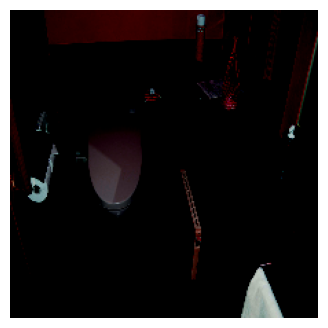

Generated Caption: a bathroom with a toilet, sink and shower.


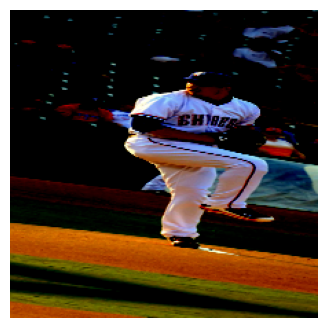

Generated Caption: a baseball player is standing on the field


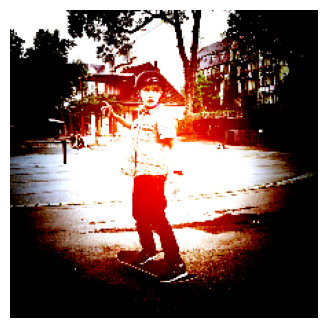

Generated Caption: a man riding a skateboard down a street.


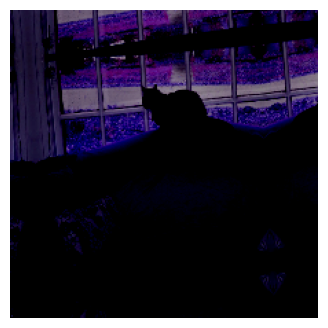

Generated Caption: a black cat sitting on top of a couch.


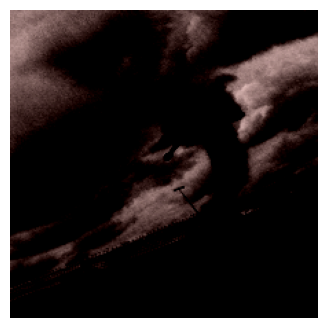

Generated Caption: a man riding a skateboard on a ramp.


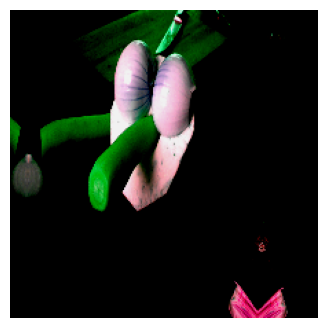

Generated Caption: a person is cutting a banana on a table.


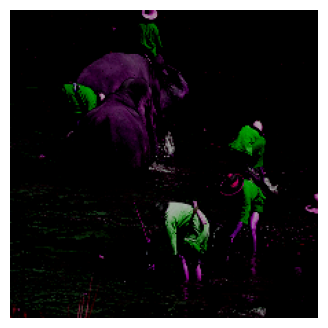

Generated Caption: with a group of people and elephants in a river.


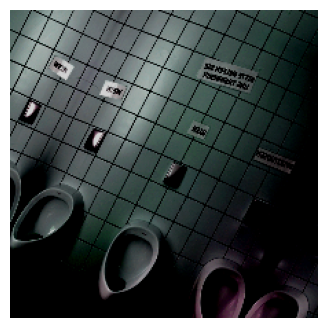

Generated Caption: a wall mounted urinal in a bathroom.


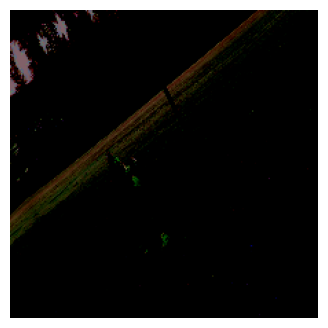

Generated Caption: a red fire hydrant in a field of grass.


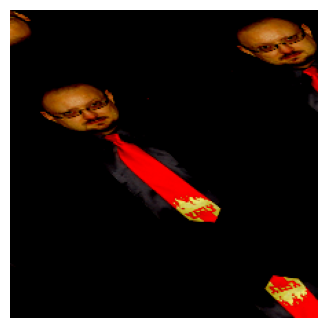

Generated Caption: a man wearing a red tie and a black jacket.


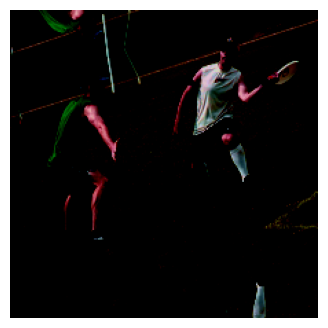

Generated Caption: some guys playing frisbee on a green field.


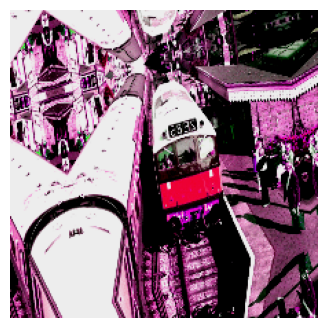

Generated Caption: a train is on the tracks in a city.


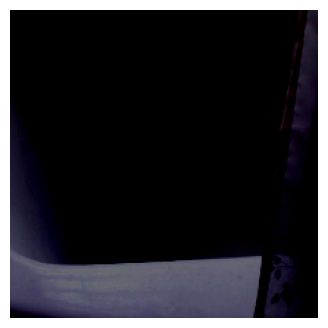

Generated Caption: a cat sitting in a bath tub.


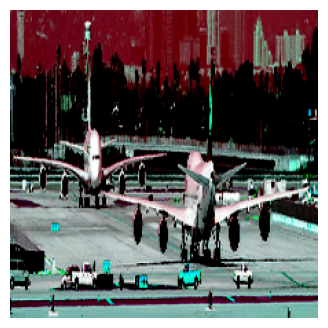

Generated Caption: a large airplane that is on a runway


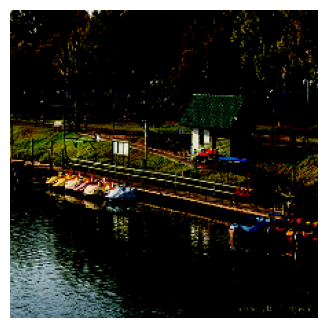

Generated Caption: a bunch of boats that are in the water.


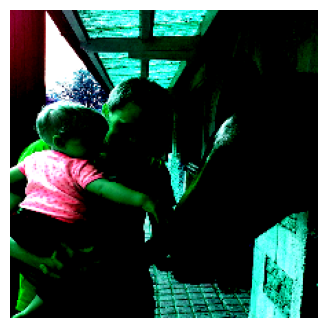

Generated Caption: a woman and a child are looking at a horse.


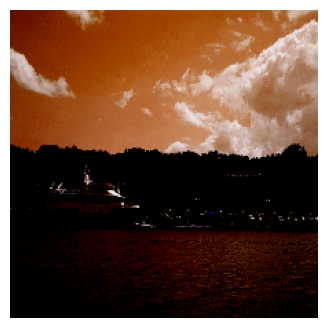

Generated Caption: a boat is docked at a pier in front of a building.


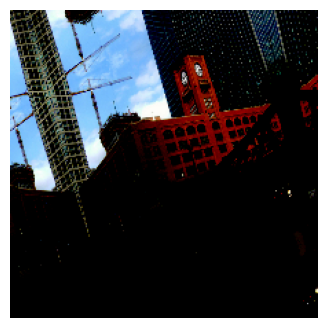

Generated Caption: a train is on a bridge over a river.


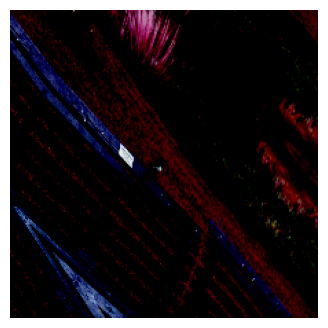

Generated Caption: a bird sitting on a park bench next to a bench.


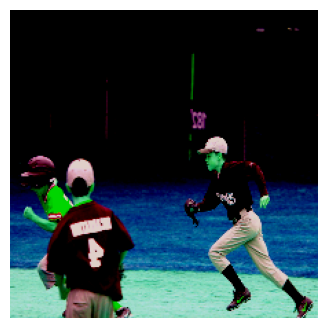

Generated Caption: a young boy is running with a baseball bat.


In [23]:
# generate sample of train dataset
for index in np.random.randint(int(val_df.shape[0]/4 - 1),size=20):
    pred_caption = generate_caption_with_image( image=val_dataset.__getitem__(index)['pixel_values'].numpy(), model=model , tokenizer=decoder_tokenizer ,
    device=device )

In [24]:
class ImagePreprocessor:
    def __init__(self, image_height, image_width):
        self.image_height = image_height
        self.image_width = image_width

        self.transforms = A.Compose([
            A.Resize(self.image_height, self.image_width),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
            ToTensorV2() 
        ])

    def preprocess(self, image_path):
        image = Image.open(image_path).convert("RGB")
        image = np.array(image) 

        transformed = self.transforms(image=image)
        image_tensor = transformed["image"] 

        return image_tensor

<ipython-input-21-a37716d75498>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.unsqueeze(torch.tensor(image), 0).to(device)


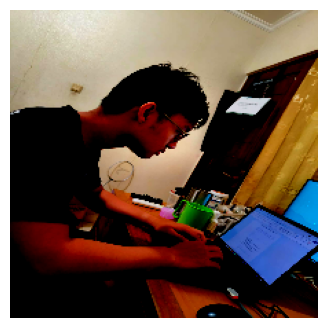

Generated Caption: a man sitting at a desk with a laptop and a cell phone.


'a man sitting at a desk with a laptop and a cell phone.'

In [25]:
sample_image = "/kaggle/input/sample-data/WhatsApp Image 2025-01-04 at 15.07.38.jpeg"

image_preprocessor = ImagePreprocessor(image_height=224, image_width=224)

image_tensor = image_preprocessor.preprocess(sample_image)

generate_caption_with_image(image_tensor, model=model, tokenizer=decoder_tokenizer, device=device)

***